In [81]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from pathlib import Path
import matplotlib.pyplot as plt

In [73]:
train_path = Path("D:/CSE BRACU/CSE428/CSE428-Image-Processing-Project/Dataset_Group1/train")
test_path = Path("D:/CSE BRACU/CSE428/CSE428-Image-Processing-Project/Dataset_Group1/test")

In [74]:
def load_images(folder_path):
    images = [] # x
    labels = [] # y
    class_dict = {}

    for sub_folder_path in folder_path.iterdir():
        if sub_folder_path.is_dir():
            class_name = sub_folder_path.name
            class_images = []

            count = 0
            for img_path in sub_folder_path.iterdir():
                image = load_img(img_path)
                image_array = img_to_array(image)

                images.append(image_array)
                labels.append(class_name)
                class_images.append(image_array)
                count+=1

            class_dict[class_name] = count

    unique_labels = np.unique(labels)

    return [[np.array(images), np.array(labels)], class_dict, unique_labels]

In [75]:
# loading the train and test data as numpy array and giving label to the train data

X_train_org, Y_train_org = load_images(train_path)[0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_org, Y_train_org, test_size=0.2, random_state=428)
X_test, Y_test = load_images(test_path)[0]

In [76]:
print(f'Train set {X_train.shape} and {Y_train.shape}')
print(f'Test set {X_test.shape} and {Y_test.shape}')
print(f'Validation set {X_validation.shape} and {Y_validation.shape}')

Train set (1720, 64, 64, 3) and (1720,)
Test set (250, 64, 64, 3) and (250,)
Validation set (430, 64, 64, 3) and (430,)


**Data Augmentation**

In [78]:
def data_augmentation(folder_path):
    folder_path = Path(folder_path)
    max_sample = max([len(list(class_folder.iterdir())) for class_folder in folder_path.iterdir()])

    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    for sub_folder_path in folder_path.iterdir():
        if sub_folder_path.is_dir():
            class_name = sub_folder_path.name
            augmentation_num = max_sample - len(list(sub_folder_path.iterdir()))
            if augmentation_num <= 0:
                continue
            
            count = 0
            for img_path in sub_folder_path.iterdir():
                if count > augmentation_num:
                    break
                count += 1
                
                img = load_img(img_path)                  # Load the image
                x = img_to_array(img)                     # Convert to numpy array
                x = x.reshape((1,) + x.shape)             # Reshape it
                
                i = 0
                for _ in datagen.flow(x, batch_size=1, save_to_dir=str(sub_folder_path), save_prefix='img', save_format='jpeg'):
                    i += 1
                    if i >= 1:
                        break

In [80]:
# after data augmentation
data_augmentation(train_path)
sample_num = load_images(train_path)[1]
print(sample_num)

{'bear': 500, 'boa-constrictor': 500, 'bullfrog': 500, 'golden-retriever': 500, 'goldfish': 500}


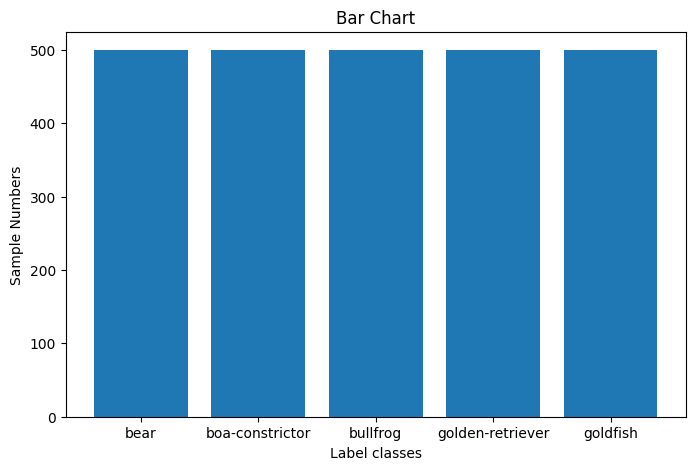

In [83]:
x = list(sample_num.keys())
y = list(sample_num.values())

plt.figure(figsize=(8, 5))
plt.bar(x, y)
plt.xlabel('Label classes')
plt.ylabel('Sample Numbers')
plt.title('Bar Chart')
plt.show()

In [84]:
X_train_org, Y_train_org = load_images(train_path)[0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_org, Y_train_org, test_size=0.2, random_state=428)
X_test, Y_test = load_images(test_path)[0]

**ResNet-34 Model**

In [ ]:
def conv2d(x, kernel, bias, stride=1, padding=0):
    return np.convolve(x, kernel, mode='same') + bias

def batchnorm2d(x, gamma, beta, epsilon=1e-5):
    mean = np.mean(x, axis=(0, 2, 3), keepdims=True)
    var = np.var(x, axis=(0, 2, 3), keepdims=True)
    x_normalized = (x - mean) / np.sqrt(var + epsilon)
    return gamma * x_normalized + beta

def relu(x):
    return np.maximum(0, x)

def basic_block(x, in_channels, out_channels, stride=1):
    shortcut = x.copy()

    # First convolution
    kernel1 = np.random.randn(out_channels, in_channels, 3, 3)
    x = conv2d(x, kernel1, bias=np.zeros(out_channels), stride=stride, padding=1)
    x = batchnorm2d(x, gamma=np.ones(out_channels), beta=np.zeros(out_channels))
    x = relu(x)

    # Second convolution
    kernel2 = np.random.randn(out_channels, out_channels, 3, 3)
    x = conv2d(x, kernel2, bias=np.zeros(out_channels), stride=1, padding=1)
    x = batchnorm2d(x, gamma=np.ones(out_channels), beta=np.zeros(out_channels))

    # Shortcut connection
    if stride != 1 or in_channels != out_channels:
        shortcut = conv2d(shortcut, kernel1[:, :, 1:, 1:], bias=np.zeros(out_channels), stride=stride)
        shortcut = batchnorm2d(shortcut, gamma=np.ones(out_channels), beta=np.zeros(out_channels))

    x += shortcut
    x = relu(x)

    return x

# Define the ResNet-34 architecture
def resnet34(input_shape=(3, 224, 224), num_classes=1000):
    x = np.random.randn(*input_shape)

    # Initial convolution
    kernel_init = np.random.randn(64, 3, 7, 7)
    x = conv2d(x, kernel_init, bias=np.zeros(64), stride=2, padding=3)
    x = batchnorm2d(x, gamma=np.ones(64), beta=np.zeros(64))
    x = relu(x)

    # Maxpooling
    x = np.max(x, axis=(2, 3))

    # Stacking layers
    num_blocks = [3, 4, 6, 3]
    in_channels = [64, 64, 128, 256, 512]
    out_channels = [64, 128, 256, 512]
    for i in range(4):
        for j in range(num_blocks[i]):
            stride = 2 if i > 0 and j == 0 else 1
            x = basic_block(x, in_channels[i], out_channels[i], stride=stride)

    # Global average pooling
    x = np.mean(x, axis=(2, 3))

    # Fully connected layer
    fc_weights = np.random.randn(num_classes, 512)
    fc_bias = np.zeros(num_classes)
    x = np.dot(x, fc_weights.T) + fc_bias

    return x

# Instantiate the ResNet-34 model
output = resnet34()

# Print the output shape
print(output.shape)

In [ ]:
def forward_pass(x, parameters):
    # Forward pass of your model
    # Replace this with the forward pass logic of your ResNet model
    # Assume output is the output of your model and params is a list of model parameters
    output = resnet34(x, *parameters)
    return output

def compute_loss(predictions, labels):
    # Example of a simple cross-entropy loss
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.sum(labels * np.log(predictions)) / len(predictions)
    return loss

def backward_pass(predictions, labels):
    # Example of a simple gradient computation for cross-entropy loss
    gradient = (predictions - labels) / len(predictions)
    return gradient

def update_parameters(parameters, gradients, learning_rate=0.001):
    updated_params = [param - learning_rate * grad for param, grad in zip(parameters, gradients)]
    return updated_params

def train_model(train_data, train_labels, test_data, test_labels, num_epochs=10, learning_rate=0.001):
    weight_matrix = np.random.randn(1000, 512)
    bias_vector = np.zeros(1000)
    model_parameters = [weight_matrix, bias_vector]

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training
        total_loss = 0.0
        correct_predictions = 0
        for i in range(len(train_data)):
            input_data = train_data[i]
            target_labels = train_labels[i]

            predictions = forward_pass(input_data, model_parameters)
            loss = compute_loss(predictions, target_labels)
            total_loss += loss

            gradient = backward_pass(predictions, target_labels)
            model_parameters = update_parameters(model_parameters, [gradient])

            # Evaluate accuracy during training
            correct_predictions += np.sum(np.argmax(predictions, axis=1) == np.argmax(target_labels, axis=1))

        average_train_loss = total_loss / len(train_data)
        train_accuracy = correct_predictions / len(train_data)
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Testing
        total_loss = 0.0
        correct_predictions = 0
        for i in range(len(test_data)):
            input_data = test_data[i]
            target_labels = test_labels[i]

            predictions = forward_pass(input_data, model_parameters)
            loss = compute_loss(predictions, target_labels)
            total_loss += loss

            # Evaluate accuracy during testing
            correct_predictions += np.sum(np.argmax(predictions, axis=1) == np.argmax(target_labels, axis=1))

        average_test_loss = total_loss / len(test_data)
        test_accuracy = correct_predictions / len(test_data)
        test_losses.append(average_test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, num_epochs + 1), train_losses, label='Train loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test loss')
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train acc')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming train_data, train_labels, test_data, and test_labels are NumPy arrays

train_model(train_data, train_labels, test_data, test_labels, num_epochs=10, learning_rate=0.001)

In [ ]:
def evaluate_classification(y_true, y_pred):
    # Confusion Matrix
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    true_negative = np.sum((y_true == 0) & (y_pred == 0))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))

    # Metrics
    accuracy_val = np.sum(y_true == y_pred) / len(y_true)
    sensitivity_val = true_positive / (true_positive + false_negative)
    specificity_val = true_negative / (true_negative + false_positive)
    ppv_val = true_positive / (true_positive + false_positive)
    npv_val = true_negative / (true_negative + false_negative)

    # F1 Score
    precision = ppv_val
    recall = sensitivity_val
    f1_val = 2 * (precision * recall) / (precision + recall)

    metrics = {
        "Accuracy": accuracy_val,
        "Sensitivity": sensitivity_val,
        "Specificity": specificity_val,
        "PPV (Positive Predictive Value)": ppv_val,
        "NPV (Negative Predictive Value)": npv_val,
        "True Positive": true_positive,
        "False Positive": false_positive,
        "True Negative": true_negative,
        "False Negative": false_negative,
        "F1 Score": f1_val
    }

    return metrics

# Example usage:
# Assuming y_true and y_pred are NumPy arrays with binary labels

resnet_result = evaluate_classification(y_true, y_pred)
print(resnet_result)

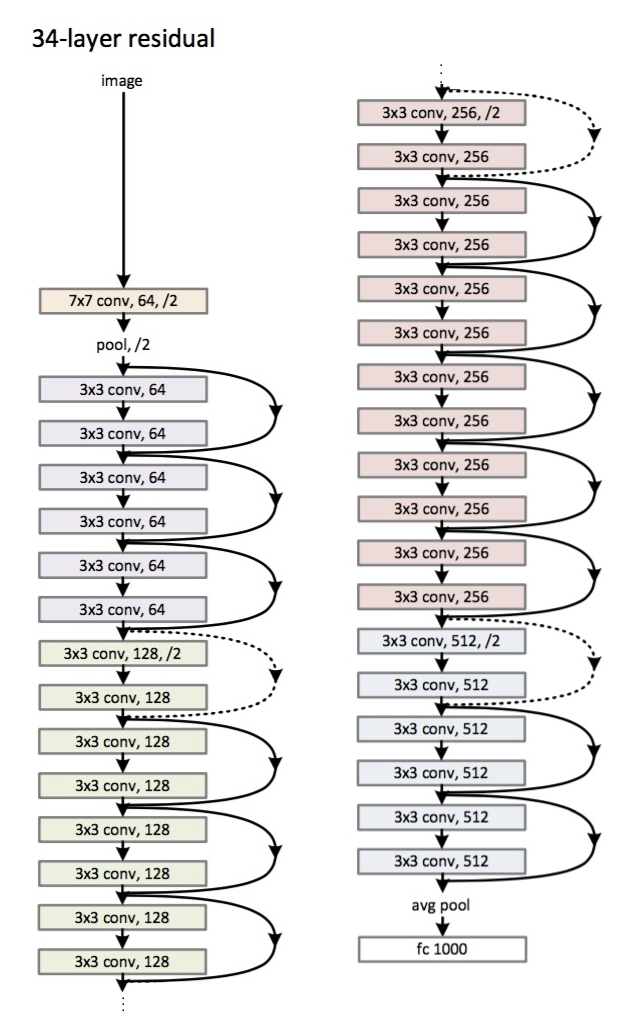

In [ ]:
def visualize_misclassified_samples(test_data, test_labels, model_parameters):
    misclassified_samples = []

    for i in range(len(test_data)):
        input_data = test_data[i]
        target_labels = test_labels[i]

        predictions = forward_pass(input_data, model_parameters)
        _, predicted_class = np.max(predictions), np.argmax(predictions)

        true_class = np.argmax(target_labels)

        if predicted_class != true_class:
            misclassified_samples.append((input_data, true_class, predicted_class))

    return misclassified_samples

weight_matrix = np.random.randn(1000, 512)
bias_vector = np.zeros(1000)
model_parameters = [weight_matrix, bias_vector]

misclassified_samples = visualize_misclassified_samples(test_data, test_labels, model_parameters)

# Display 2 or 3 misclassified samples and their actual labels
for i in range(min(3, len(misclassified_samples))):
    input_data, true_class, predicted_class = misclassified_samples[i]

    # Display the misclassified sample (you may need to adjust this depending on your data)
    plt.imshow(np.transpose(input_data, (1, 2, 0)))
    plt.title(f'True Class: {true_class}, Predicted Class: {predicted_class}')
    plt.show()